In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import laplacian_kernel
from sklearn.model_selection import train_test_split

/home/dboiko/.conda/envs/nbo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X = np.load('/home/dboiko/simg-2/experiments/downstream_model/additional_benchmarks/qm7/soap_qm7.npy')

In [16]:
results = []

for target in ["atomization", "dipole", "gap", "homo"]:
    y = np.loadtxt(f'/home/dboiko/SPAHM/SPAHM/1_QM7/target/{target}.dat')

    test_idx = np.loadtxt('/home/dboiko/SPAHM/test-indices/QM7_test_indices.dat').astype(int)
    train_indices = np.array([i for i in range(X.shape[0]) if i not in test_idx])

    test_size = 0.2
    sigma=500
    eta=1e-5
    n_rep=5

    X_train, X_test, y_train, y_test = X[train_indices], X[test_idx], y[train_indices], y[test_idx]

    all_indices_train = np.arange(X_train.shape[0])
    K_all  = laplacian_kernel(X_train, X_train, 1.0/sigma)
    Ks_all = laplacian_kernel(X_test,  X_train, 1.0/sigma)
    K_all[np.diag_indices_from(K_all)] += eta

    np.random.seed(42)

    train_size = np.linspace(0.1, 0.9, 9)

    for size in tqdm(train_size):
        size_train = int(np.floor(X_train.shape[0]*size))
        maes = []
        for rep in range(n_rep):
            train_idx = np.random.choice(all_indices_train, size = size_train, replace=False)
            y_kf_train = y_train[train_idx]
            K  = K_all [np.ix_(train_idx,train_idx)]
            Ks = Ks_all[:,train_idx]
            alpha = np.linalg.solve(K, y_kf_train)
            y_kf_predict = np.dot(Ks, alpha)
            maes.append(np.mean(np.abs(y_test-y_kf_predict)))

        results.append({
            'target': target,
            'size': size_train,
            'mae': np.mean(maes),
            'std': np.std(maes)
        })

results = pd.DataFrame(results)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.28s/it]


In [15]:
results.to_csv('1117_results_soap.csv', index=False)

In [13]:
results

,target,size,mae,std
0,atomization,573,44.364747,0.808804
1,atomization,1146,37.019602,1.134151
2,atomization,1719,32.883900,0.771789
3,atomization,2292,29.618085,0.179845
4,atomization,2866,28.090769,0.277536
5,atomization,3439,26.172057,0.505945
6,atomization,4012,25.011557,0.279311
7,atomization,4585,24.155793,0.172250
8,atomization,5158,22.832659,0.106332
9,dipole,573,0.253562,0.005765


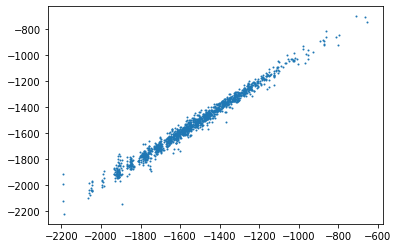

In [5]:
import matplotlib.pyplot as plt

plt.scatter(
    y_test,
    y_kf_predict,
    s=1
)